# Analyzing word and document frequency: tf-idf

A central question in text mining and natural language processing is how to quantify what a document is about. Can we do this by looking at the words that make up the document? One measure of how important a word may be is its term frequency (tf) - this is how frequently a word occurs in a document - as we saw in Lab 2. However, there are words in a document that occur many times but may not be important. In English these words are most often things like “the”, “is”, “of”, and so forth. We might take the approach of adding words like these to a list of stop words and removing them before analysis, but it is possible that some of these words m::ight be more important in some documents than others. A list of stop words is not a very sophisticated approach to adjusting term frequency for commonly used words.

Another approach is to look at a term’s inverse document frequency (idf), which decreases the weight for commonly used words and increases the weight for words that are not used very much in a collection of documents. This can be combined with term frequency to calculate a term’s tf-idf (the two quantities multiplied together), the frequency of a term adjusted for how rarely it is used.

The tf-idf statistic is intended to measure how important a word is to a document in a collection (or corpus) of documents, for example, to one novel in a collection of novels or to one website in a collection of websites.

$$
    idf(term) = ln(\frac{n_{docs}}{n_{docs\_with\_terms}})
$$

In [1]:
# Term frequency in Jane Austen’s novels
# Let’s start by looking at the published novels of Jane Austen first examinining term frequency and then tf-idf.

# We’ll get 4 of Jane Austen’s novels: Sense and Sensibility, Pride and Prejudice, Emma and Persuasion

import pandas as pd
import gutenbergpy.textget
from tidytext import unnest_tokens
import nltk
nltk.download('punkt')

raw_book = gutenbergpy.textget.get_text_by_id(161)
sense_sensibility_text = gutenbergpy.textget.strip_headers(raw_book).decode("utf-8")

raw_book = gutenbergpy.textget.get_text_by_id(1342)
pride_prejudice_text = gutenbergpy.textget.strip_headers(raw_book).decode("utf-8")

raw_book = gutenbergpy.textget.get_text_by_id(158)
emma_text = gutenbergpy.textget.strip_headers(raw_book).decode("utf-8")

raw_book = gutenbergpy.textget.get_text_by_id(105)
persuasion_text = gutenbergpy.textget.strip_headers(raw_book).decode("utf-8")



# Create our dataframe
import re
sense_sensibility_lines = sense_sensibility_text.splitlines()
pride_prejudice_lines = pride_prejudice_text.splitlines()
emma_lines = emma_text.splitlines()
persuasion_lines = persuasion_text.splitlines()

sense_sensibility_df = pd.DataFrame({
    "content": sense_sensibility_lines,
    "line": list(range(len(sense_sensibility_lines)))
})

pride_prejudice_df = pd.DataFrame({
    "content": pride_prejudice_lines,
    "line": list(range(len(pride_prejudice_lines)))
})

emma_df = pd.DataFrame({
    "content": emma_lines,
    "line": list(range(len(emma_lines)))
})

persuasion_df = pd.DataFrame({
    "content": persuasion_lines,
    "line": list(range(len(persuasion_lines)))
})


sense_sensibility_df = sense_sensibility_df.assign(book='Sense and Sensibility')
pride_prejudice_df = pride_prejudice_df.assign(book="Pride and Prejudice")
emma_df = emma_df.assign(book='Emma')
persuasion_df = persuasion_df.assign(book='Persuasion')

jane_austen_list = [sense_sensibility_df, pride_prejudice_df, emma_df, persuasion_df]
jane_austen_df = pd.concat(jane_austen_list)
jane_austen_df


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bogda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,content,line,book
0,,0,Sense and Sensibility
1,[Illustration],1,Sense and Sensibility
2,,2,Sense and Sensibility
3,,3,Sense and Sensibility
4,,4,Sense and Sensibility
...,...,...,...
8341,,8341,Persuasion
8342,,8342,Persuasion
8343,,8343,Persuasion
8344,,8344,Persuasion


In [2]:
from tidytext import unnest_tokens
jane_austen_df = unnest_tokens(jane_austen_df, "word", "content")
jane_austen_df.reset_index(drop=True, inplace=True)
jane_austen_df


,line,book,word
0,0,Sense and Sensibility,NaN
1,1,Sense and Sensibility,illustration
2,2,Sense and Sensibility,NaN
3,3,Sense and Sensibility,NaN
4,4,Sense and Sensibility,NaN
...,...,...,...
506506,8341,Persuasion,NaN
506507,8342,Persuasion,NaN
506508,8343,Persuasion,NaN
506509,8344,Persuasion,NaN


In [3]:
# Count the number of occurrences of each word and sort the result

from siuba import *
from plotnine import *
book_words = count(jane_austen_df, _.book, _.word, sort=True)
book_words


,book,word,n
0,Emma,to,5141
1,Emma,the,5123
2,Emma,and,4542
3,Pride and Prejudice,the,4324
4,Emma,of,4263
...,...,...,...
29792,Emma,threaten,1
29793,Emma,threadbare,1
29794,Emma,thousands—,1
29795,Emma,thought—she,1


# Exercise 1


### 1.  Create a dataframe similar to book_words **to which you add a new column called "total"**. This column will have the **total number of words** for the book from which the current word is coming from. 
Here's an example of what the new dataframe would look like:

-|book|word|n|total|
---:|---:|---:|---:|---:|
0|Emma|to|5141|164343
1|Emma|the|5123|164343
2|Emma|and|4542|164343 
3|Pride and Prejudice|the|4324|126787 
4|Emma|of|4263|164343 

In [4]:
# drop NaN words
total_words_per_book = jane_austen_df.dropna()
total_words_per_book = count(total_words_per_book, _.book, sort=True)
total_words_per_book.rename(columns={'n': 'total'}, inplace=True)
total_words_per_book


,book,total
0,Emma,164343
1,Pride and Prejudice,126787
2,Sense and Sensibility,123826
3,Persuasion,83327


In [5]:
histogram_df = book_words.join(
    total_words_per_book.set_index('book'), on='book')

histogram_df


,book,word,n,total
0,Emma,to,5141,164343
1,Emma,the,5123,164343
2,Emma,and,4542,164343
3,Pride and Prejudice,the,4324,126787
4,Emma,of,4263,164343
...,...,...,...,...
29792,Emma,threaten,1,164343
29793,Emma,threadbare,1,164343
29794,Emma,thousands—,1,164343
29795,Emma,thought—she,1,164343



### 2. If your dataframe is in the right format from exercise 1 then **run the commented code below**. 

This will plot the 'count' vs 'n/total' graphs for all of the books. You will see how many words there are for each term frequency (tf is n/total).
What can we observe in the graph?


C:\Python310\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Python310\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_bin : Removed 998 rows containing non-finite values.
C:\Python310\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


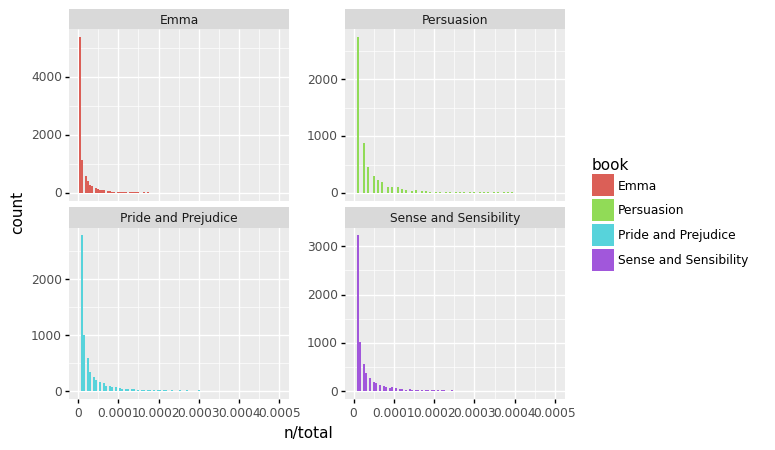

<ggplot: (99026790443)>

In [6]:
from plotnine import *
ggplot(histogram_df) +\
    aes(x="n/total", fill='book') +\
    geom_histogram(bins=100) +\
    xlim(None, 0.0005) +\
    facet_wrap('~book', ncol = 2, scales = "free_y") +\
    theme(subplots_adjust={'wspace': 0.25})



### 3. **Create a new dataframe that adds the "rank" and "term_frequency" columns**. 

Rank is the ranking of how often the word appears inside the book that it comes from. E.g. The word that appears the most often in Emma will have rank 1, the 3rd most common word will have rank 3, etc.

Term_frequency is obtained by the formula: $term\_frequency = \frac{n}{total}$, where n is the number of word's appearances in the book and total is the total number of words in the book.

The new df would look something like this:

-|book|word|n|total|rank|term_frequency 
---:|---:|---:|---:|---:|---:|---:|
0|Emma|to|5141|164343|1|0.032282 
1|Emma|the|5123|164343|2|0.031173 
2|Emma|and|4542|164343|3|0.027637 
3|Pride and Prejudice|the|4324|126787|1|0.034104 
4|Emma|of|4263|164343|4|0.025940 


In [7]:
book_words_ranked = histogram_df
book_words_ranked['term_frequency'] = book_words_ranked['n']/book_words_ranked['total']

def rank_words(df):
    df['rank'] = list(range(1, len(df) + 1))
    return df

book_words_ranked = book_words_ranked.groupby('book').apply(rank_words)

book_words_ranked


,book,word,n,total,term_frequency,rank
0,Emma,to,5141,164343,0.031282,1
1,Emma,the,5123,164343,0.031173,2
2,Emma,and,4542,164343,0.027637,3
3,Pride and Prejudice,the,4324,126787,0.034104,1
4,Emma,of,4263,164343,0.025940,4
...,...,...,...,...,...,...
29792,Emma,threaten,1,164343,0.000006,9834
29793,Emma,threadbare,1,164343,0.000006,9835
29794,Emma,thousands—,1,164343,0.000006,9836
29795,Emma,thought—she,1,164343,0.000006,9837



### 4. **Draw a graph that shows 'rank' vs 'term_frequency' for all of the 4 books** (x-axis rank, y-axis term_frequency). 


C:\Python310\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Python310\lib\site-packages\plotnine\facets\facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
C:\Python310\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 6190 rows containing missing values.


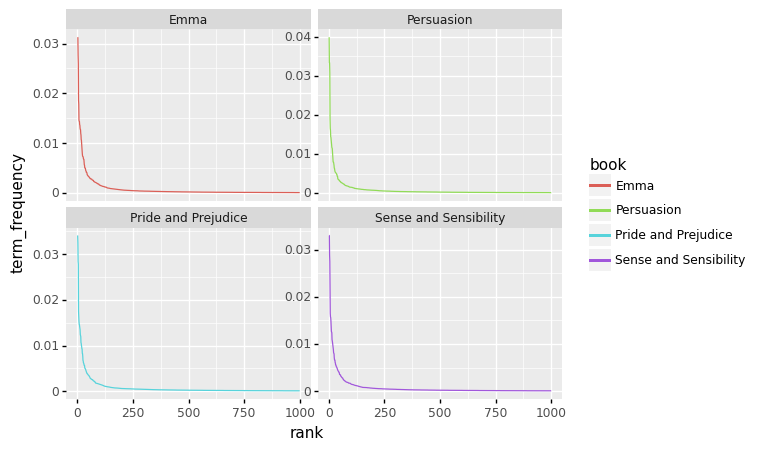

<ggplot: (98965142117)>

In [8]:
# graph 'rank' vs 'term_frequency' for each book
ggplot(book_words_ranked) +\
    aes(x='rank', y='term_frequency', group='book', color='book') +\
    geom_line() +\
    facet_wrap('~book', ncol = 2, scales = "free_y") +\
    xlim(0, 1000)


### Zipf’s law
Distributions like those shown in the figure you created in exercise 1.2 are typical in language. In fact, those types of long-tailed distributions are so common in any given corpus of natural language (like a book, or a lot of text from a website, or spoken words) that the relationship between the frequency that a word is used and its rank has been the subject of study; a classic version of this relationship is called Zipf’s law, after George Zipf, a 20th century American linguist.
Zipf’s law states that the frequency that a word appears with is inversely proportional to its rank.
 
For exercise 1.4 we've tried seeing Zipf's law in action.

Zipf’s law is often visualized by plotting rank on the x-axis and term frequency on the y-axis, on logarithmic scales. Plotting this way, an inversely proportional relationship will have a constant, negative slope.

Classic versions of Zip’s law have: $frequency = \frac{1}{rank}$

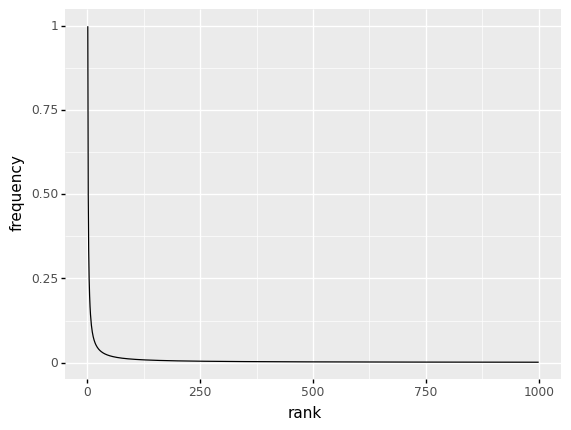

<ggplot: (98965160471)>

In [9]:
zipf = pd.DataFrame(data={'rank': list(range(1, 1001)), 'frequency': [1 / i for i in range(1, 1001)]})

ggplot(zipf) +\
    aes(x='rank', y='frequency') +\
    geom_line()

# TF_IDF


### The bind_tf_idf() function
The idea of tf-idf is to find the important words for the content of each document by decreasing the weight for commonly used words and increasing the weight for words that are not used very much in a collection or corpus of documents, in this case, the group of Jane Austen’s novels as a whole. Calculating tf-idf attempts to find the words that are important (i.e., common) in a text, but not too common. Let’s do that now.

In [10]:
from tidytext import *

# tidytext's bind_tf_idf can provide us with tf, idf and tf_idf information
book_tf_idf = bind_tf_idf(book_words, 'word', 'book', 'n')
book_tf_idf


,book,word,n,tf,idf,tf_idf
0,Emma,to,5141,0.031282,0.000000,0.000000
1,Emma,the,5123,0.031173,0.000000,0.000000
2,Emma,and,4542,0.027637,0.000000,0.000000
3,Pride and Prejudice,the,4324,0.034104,0.000000,0.000000
4,Emma,of,4263,0.025940,0.000000,0.000000
...,...,...,...,...,...,...
29792,Emma,threaten,1,0.000006,1.386294,0.000008
29793,Emma,threadbare,1,0.000006,0.693147,0.000004
29794,Emma,thousands—,1,0.000006,1.386294,0.000008
29795,Emma,thought—she,1,0.000006,1.386294,0.000008


In [11]:
# Sort by tf_idf in descending order
from siuba import *
arrange(book_tf_idf, -_.tf_idf)

,book,word,n,tf,idf,tf_idf
123,Sense and Sensibility,elinor,678,0.005475,1.386294,0.007591
148,Sense and Sensibility,marianne,561,0.004531,1.386294,0.006281
209,Pride and Prejudice,darcy,415,0.003273,1.386294,0.004538
303,Persuasion,elliot,254,0.003048,1.386294,0.004226
38,Pride and Prejudice,“,1792,0.014134,0.287682,0.004066
...,...,...,...,...,...,...
29620,Pride and Prejudice,merits,1,0.000008,0.000000,0.000000
29657,Emma,theirs,1,0.000006,0.000000,0.000000
29677,Pride and Prejudice,misled,1,0.000008,0.000000,0.000000
29683,Pride and Prejudice,mechanically,1,0.000008,0.000000,0.000000


In [12]:
from siuba import *

# Get the first 15 entries from each book
tf_idf_df = ungroup(group_by(arrange(book_tf_idf, -_.tf_idf), 'book').head(15))
tf_idf_df


,book,word,n,tf,idf,tf_idf
123,Sense and Sensibility,elinor,678,0.005475,1.386294,0.007591
148,Sense and Sensibility,marianne,561,0.004531,1.386294,0.006281
209,Pride and Prejudice,darcy,415,0.003273,1.386294,0.004538
303,Persuasion,elliot,254,0.003048,1.386294,0.004226
38,Pride and Prejudice,“,1792,0.014134,0.287682,0.004066
40,Pride and Prejudice,”,1741,0.013732,0.287682,0.003950
26,Emma,“,2099,0.012772,0.287682,0.003674
27,Emma,”,2090,0.012717,0.287682,0.003659
199,Emma,weston,429,0.002610,1.386294,0.003619
48,Sense and Sensibility,“,1549,0.012509,0.287682,0.003599


In [13]:
# Get df sorted by book and tf_idf
from siuba import *
ordered_tf_idf_df = arrange(tf_idf_df, _.book, -_.tf_idf)
ordered_tf_idf_df


,book,word,n,tf,idf,tf_idf
26,Emma,“,2099,0.012772,0.287682,0.003674
27,Emma,”,2090,0.012717,0.287682,0.003659
199,Emma,weston,429,0.002610,1.386294,0.003619
101,Emma,emma,821,0.004996,0.693147,0.003463
222,Emma,elton,380,0.002312,1.386294,0.003205
226,Emma,knightley,366,0.002227,1.386294,0.003087
269,Emma,woodhouse,299,0.001819,1.386294,0.002522
173,Emma,harriet,474,0.002884,0.693147,0.001999
79,Emma,’,1114,0.006779,0.287682,0.001950
334,Emma,fairfax,226,0.001375,1.386294,0.001906


C:\Python310\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


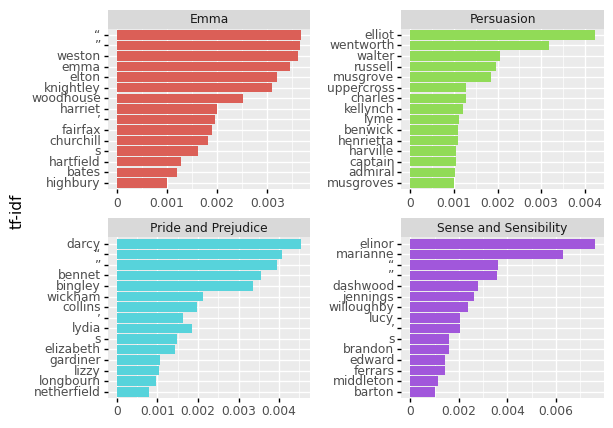

<ggplot: (98968416575)>

In [14]:
from siuba.dply.forcats import fct_reorder
ggplot(ordered_tf_idf_df) +\
    aes(x=fct_reorder(ordered_tf_idf_df['word'], x=ordered_tf_idf_df['tf_idf']), y='tf_idf', fill='book') +\
    coord_flip() +\
    geom_col(show_legend = False) +\
    facet_wrap('~book', ncol = 2, scales = "free") +\
    labs(x = "tf-idf", y = None) +\
    theme(subplots_adjust={'wspace': 0.15}) +\
    theme(subplots_adjust={'wspace': 0.45, 'hspace': 0.3}) +\
    scale_x_discrete()

# A corpus of physics texts
Let’s work with another corpus of documents to see what terms are important in a different set of works. In fact, let’s leave the world of fiction and narrative entirely. Let’s download some classic physics texts from Project Gutenberg and see what terms are important in these works, as measured by tf-idf. We'll download Discourse on Floating Bodies by Galileo Galilei, Treatise on Light by Christiaan Huygens, Experiments with Alternate Currents of High Potential and High Frequency by Nikola Tesla, and Relativity: The Special and General Theory by Albert Einstein.
This is a pretty diverse bunch. They may all be physics classics, but they were written across a 300-year timespan and some of them were first written in other languages before being translated to English. Perfectly homogeneous is what these are not, but that doesn’t stop this from being an interesting exercise!


# Exercise 2

1. Create a dataframe called physics_df that contains books from the following 4 authors: Galileo Galilei (37729), Christiaan Huygen (14725), Nikola Tesla (13476), Albert Einstein (30155) and contains the 'line', 'book' and 'word' columns.


In [15]:
ids = [
    {'id': 37729, 'name': 'Galilei'}, 
    {'id': 14725, 'name': 'Huygen'}, 
    {'id': 13476, 'name': 'Tesla'}, 
    {'id': 30155, 'name': 'Einstein'}
]

def create_df(book_id, book_name):
    raw_book = gutenbergpy.textget.get_text_by_id(book_id)
    text = gutenbergpy.textget.strip_headers(raw_book).decode("utf-8")

    lines = text.splitlines()

    df = pd.DataFrame({
        "content": lines,
        "line": list(range(len(lines)))
    })

    df = df.assign(book=book_name)
    
    return df

dfs = list(map(lambda x: create_df(x['id'], x['name']), ids))

physics_df = pd.concat(dfs)
physics_df = unnest_tokens(physics_df, "word", "content")
physics_df = physics_df.dropna().reset_index(drop=True)

physics_df.head(n=10)

,line,book,word
0,6,Galilei,transcribers
1,6,Galilei,notes
2,8,Galilei,all
3,8,Galilei,apparent
4,8,Galilei,printers
5,8,Galilei,errors
6,8,Galilei,retained
7,8,Galilei,variation
8,8,Galilei,in
9,8,Galilei,punctuation



2. Make use of the previously created dataframe to obtain a new one containing the 'book', 'word', 'n', 'tf', 'idf', 'tf_idf' columns.


In [16]:
physics_df = count(physics_df, _.book, _.word, sort=True)
physics_df = bind_tf_idf(physics_df, 'word', 'book', 'n')

physics_df


,book,word,n,tf,idf,tf_idf
0,Galilei,the,3775,0.094229,0.000000,0.000000
1,Tesla,the,3593,0.091595,0.000000,0.000000
2,Huygen,the,3553,0.093062,0.000000,0.000000
3,Einstein,the,2992,0.095417,0.000000,0.000000
4,Galilei,of,2051,0.051196,0.000000,0.000000
...,...,...,...,...,...,...
12810,Galilei,stir,1,0.000025,1.386294,0.000035
12811,Galilei,steeped,1,0.000025,1.386294,0.000035
12812,Galilei,stayes,1,0.000025,1.386294,0.000035
12813,Galilei,stated,1,0.000025,0.000000,0.000000



3. Obtain the 15 most relevant words from each book (based on tf_idf) in descending order and then plot this data in order to better visualize the most relevant words per book.


C:\Python310\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


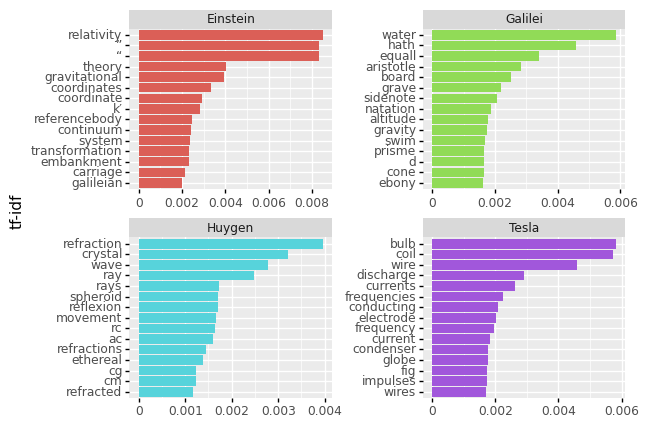

<ggplot: (98968795124)>

In [17]:
arranged_pysics_words = arrange(ungroup(group_by(arrange(physics_df, -_.tf_idf), 'book').head(15)), _.book, -_.tf_idf)

ggplot(arranged_pysics_words) +\
    aes(x=fct_reorder(arranged_pysics_words['word'], x=arranged_pysics_words['tf_idf']), y='tf_idf', fill='book') +\
    coord_flip() +\
    geom_col(show_legend=False) +\
    facet_wrap('~book', ncol=2, scales="free") +\
    labs(x="tf-idf", y=None) +\
    theme(subplots_adjust={'wspace': 0.45, 'hspace': 0.3}) +\
    scale_x_discrete()



4. Consider 1 or 2 letter tokens that occur in the top 15 tf_idf words as stop words (things like “, measurement units, constants, etc.) and **get rid of them**. 


C:\Python310\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


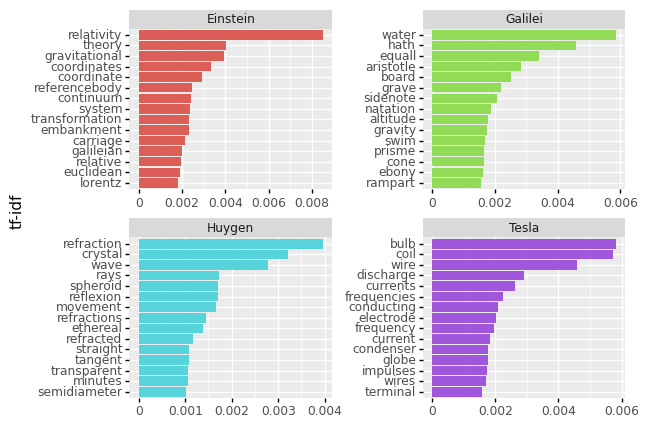

<ggplot: (98973077258)>

In [18]:
physics_df_filtered = physics_df[physics_df['word'].str.len() > 3]

arranged_pysics_words_filtered = arrange(ungroup(
    group_by(arrange(physics_df_filtered, -_.tf_idf), 'book').head(15)), _.book, -_.tf_idf)

ggplot(arranged_pysics_words_filtered) +\
    aes(x=fct_reorder(arranged_pysics_words_filtered['word'], x=arranged_pysics_words_filtered['tf_idf']), y='tf_idf', fill='book') +\
    coord_flip() +\
    geom_col(show_legend=False) +\
    facet_wrap('~book', ncol=2, scales="free") +\
    labs(x="tf-idf", y=None) +\
    theme(subplots_adjust={'wspace': 0.45, 'hspace': 0.3}) +\
    scale_x_discrete()


# Exercise 3

1. Choose any 4 documents (e.g. 4 different books from Gutenberg) and create the dataframe needed in order to plot top 15 most relevant words (based on tf_idf). Draw the graphs showing 15 most relevant words / book.

    Look at the data. Are the words something you expected? Are there surprises? 


In [19]:
books = [
    {'id': 46963, 'name': 'Astrology'},
    {'id': 43548, 'name': 'Tarot'},
    {'id': 27755, 'name': 'Alchemy'},
    {'id': 42008, 'name': 'Fortune Telling'}
]

dfs = list(map(lambda x: create_df(x['id'], x['name']), books))

pseudoscience_df = pd.concat(dfs)
pseudoscience_df = unnest_tokens(pseudoscience_df, "word", "content")
pseudoscience_df = pseudoscience_df.dropna()
pseudoscience_df.reset_index(drop=True, inplace=True)
pseudoscience_df


,line,book,word
0,0,Astrology,reiner
1,0,Astrology,ruf
2,0,Astrology,and
3,0,Astrology,the
4,0,Astrology,online
...,...,...,...
215425,4338,Fortune Telling,w
215426,4338,Fortune Telling,26
215427,4338,Fortune Telling,st
215428,4338,Fortune Telling,new


In [20]:
pseudoscience_df = count(pseudoscience_df, _.book, _.word, sort=True)
pseudoscience_df = bind_tf_idf(pseudoscience_df, 'word', 'book', 'n')

pseudoscience_df


,book,word,n,tf,idf,tf_idf
0,Alchemy,the,10324,0.089879,0.000000,0.000000
1,Alchemy,of,4662,0.040587,0.000000,0.000000
2,Tarot,the,3184,0.089280,0.000000,0.000000
3,Astrology,the,3165,0.088611,0.000000,0.000000
4,Alchemy,and,3009,0.026196,0.000000,0.000000
...,...,...,...,...,...,...
25735,Astrology,121,1,0.000028,0.693147,0.000019
25736,Astrology,1211,1,0.000028,1.386294,0.000039
25737,Astrology,1215,1,0.000028,1.386294,0.000039
25738,Astrology,1218,1,0.000028,1.386294,0.000039


C:\Python310\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


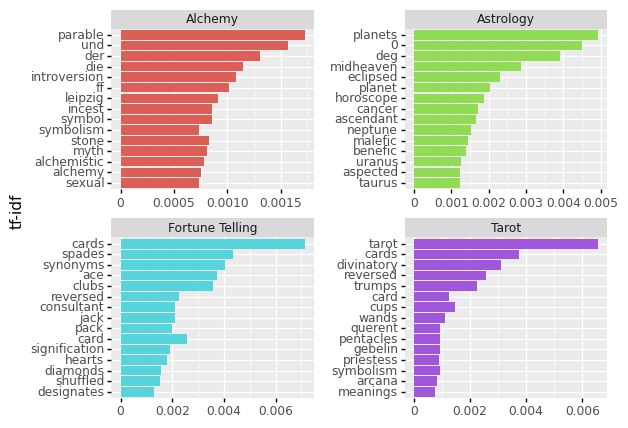

<ggplot: (98968493087)>

In [21]:
arranged_pseudoscience_words = arrange(ungroup(
    group_by(arrange(pseudoscience_df, -_.tf_idf), 'book').head(15)), _.book, -_.tf_idf)

ggplot(arranged_pseudoscience_words) +\
    aes(x=fct_reorder(arranged_pseudoscience_words['word'], x=arranged_pseudoscience_words['tf_idf']), y='tf_idf', fill='book') +\
    coord_flip() +\
    geom_col(show_legend=False) +\
    facet_wrap('~book', ncol=2, scales="free") +\
    labs(x="tf-idf", y=None) +\
    theme(subplots_adjust={'wspace': 0.45, 'hspace': 0.3}) +\
    scale_x_discrete()



2. Make use of the afinn sentiment lexicon and compute the total sentiment of these top 15 words per book. Compare the result with the sentiment of the entire book (e.g. applying afinn directly on the entire text).

    Suggestion - you can add a new column containing the score of the word to the dataframe.
    Observation - the total sentiment of top 15 words will be calculated as sum of word_sentiment_score * number_of_occurrences for each word. This is possible to yield a negative value.

In [22]:
books = [
    {'id': 996, 'name': 'Don Quixote'},
    {'id': 8486, 'name': 'Ghost Stories of an Antiquary'},
    {'id': 2600, 'name': 'War and Peace'},
    {'id': 164, 'name': 'Twenty Thousand Leagues under the Sea'}
]

dfs = list(map(lambda x: create_df(x['id'], x['name']), books))

In [23]:
sentiment_books = pd.concat(dfs)
sentiment_books = unnest_tokens(sentiment_books, "word", "content")
sentiment_books = sentiment_books.dropna()
sentiment_books = sentiment_books[sentiment_books['word'].str.len() > 2]
sentiment_books = sentiment_books.reset_index(drop=True)
sentiment_books = count(sentiment_books, _.book, _.word, sort=True)
sentiment_books = bind_tf_idf(sentiment_books, 'word', 'book', 'n')

sentiment_books


,book,word,n,tf,idf,tf_idf
0,War and Peace,the,34388,0.075629,0.000000,0.000000
1,Don Quixote,the,22278,0.067519,0.000000,0.000000
2,War and Peace,and,22078,0.048556,0.000000,0.000000
3,Don Quixote,and,17574,0.053262,0.000000,0.000000
4,Twenty Thousand Leagues under the Sea,the,8414,0.103805,0.000000,0.000000
...,...,...,...,...,...,...
51845,Twenty Thousand Leagues under the Sea,appendages,1,0.000012,1.386294,0.000017
51846,Twenty Thousand Leagues under the Sea,appendage,1,0.000012,1.386294,0.000017
51847,Twenty Thousand Leagues under the Sea,appellation,1,0.000012,0.287682,0.000004
51848,Twenty Thousand Leagues under the Sea,appeal,1,0.000012,0.287682,0.000004


C:\Python310\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


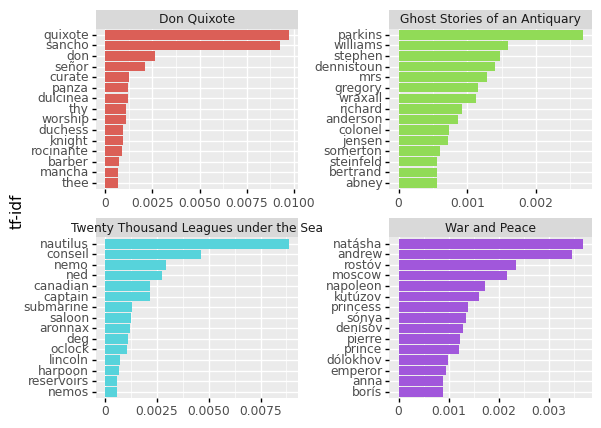

<ggplot: (98963991078)>

In [24]:
arranged_sentiment_books = arrange(ungroup(
    group_by(arrange(sentiment_books, -_.tf_idf), 'book').head(15)), _.book, -_.tf_idf)

ggplot(arranged_sentiment_books) +\
    aes(x=fct_reorder(arranged_sentiment_books['word'], x=arranged_sentiment_books['tf_idf']), y='tf_idf', fill='book') +\
    coord_flip() +\
    geom_col(show_legend=False) +\
    facet_wrap('~book', ncol=2, scales="free") +\
    labs(x="tf-idf", y=None) +\
    theme(subplots_adjust={'wspace': 0.45, 'hspace': 0.3}) +\
    scale_x_discrete()


In [25]:
from afinn import Afinn
afinn = Afinn()

def get_total_score(df):
    text = df['word'].str.cat(sep=' ')
    
    return afinn.score(text)

top_scores = arranged_sentiment_books.groupby('book').apply(get_total_score)
scores = sentiment_books

print(top_scores)

book
Don Quixote                              0.0
Ghost Stories of an Antiquary            0.0
Twenty Thousand Leagues under the Sea    0.0
War and Peace                            0.0
dtype: float64
